# GRAPE calculation of control fields for single-qubit rotation

Robert Johansson (robert@riken.jp)

In [142]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

In [143]:
from qutip import *
from qutip.control import *

In [144]:
T = 1
times = np.linspace(0, T, 100)

In [145]:
theta, phi = np.random.rand(2)

In [146]:
# target unitary transformation (random single qubit rotation)
U = rz(phi) * rx(theta); U

<ipython-input-146-a230f0787298>:2: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U = rz(phi) * rx(theta); U


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.95794133-0.28415426j -0.01139224-0.03840555j]
 [ 0.01139224-0.03840555j  0.95794133+0.28415426j]]

In [194]:
phase_factor = np.sin(np.pi/3)
# phase_factor = 1

In [267]:
R = 500
H_ops = [sigmax(), sigmay(), sigmaz()]
H_ops = [np.sin(phase_factor)*sigmax() ,np.cos(phase_factor) * sigmay()]#, sigmaz()]

H_labels = [r'$u_{x}$',
            r'$u_{y}$',
            r'$u_{z}$',
        ]

In [268]:
H0 = 0 * pi * sigmaz()

# GRAPE

In [269]:
from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

In [270]:
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [271]:
u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

In [272]:
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2*pi/T, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time:  11.49s. Est. time left: 00:00:01:43
20.0%. Run time:  23.52s. Est. time left: 00:00:01:34
30.0%. Run time:  35.54s. Est. time left: 00:00:01:22
40.0%. Run time:  47.54s. Est. time left: 00:00:01:11
50.0%. Run time:  59.55s. Est. time left: 00:00:00:59
60.0%. Run time:  71.60s. Est. time left: 00:00:00:47
70.0%. Run time:  83.57s. Est. time left: 00:00:00:35
80.0%. Run time:  95.49s. Est. time left: 00:00:00:23
90.0%. Run time: 107.59s. Est. time left: 00:00:00:11
Total run time: 119.38s


## Plot control fields for iSWAP gate in the presense of single-qubit tunnelling

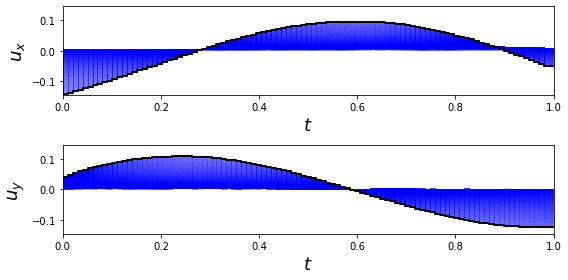

In [273]:
plot_grape_control_fields(times, result.u[:,:,:] / (2 * pi), H_labels, uniform_axes=True);

In [274]:
# target unitary
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.95794133-0.28415426j -0.01139224-0.03840555j]
 [ 0.01139224-0.03840555j  0.95794133+0.28415426j]]

In [275]:
# unitary from grape pulse
result.U_f

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.99538051-0.04618412j -0.03848005-0.07485952j]
 [ 0.03848005-0.07485952j  0.99538051+0.04618412j]]

In [276]:
# target / result overlap
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f))**2

(0.9699529392676857, 0.9408087043940228)

### Verify correctness of the Hamiltonian pulses by integration

In [277]:
c_ops = []

In [278]:
# U_f_numerical = propagator(result.H_t, times[-1], c_ops, args={})

In [279]:
# U_f_numerical

In [280]:
# _overlap(U, U_f_numerical)

# Bloch sphere dynamics

In [281]:
psi0 = basis(2, 0)
e_ops = [sigmax(), sigmay(), sigmaz()]

In [282]:
me_result = mesolve(result.H_t, psi0, times, c_ops, e_ops)

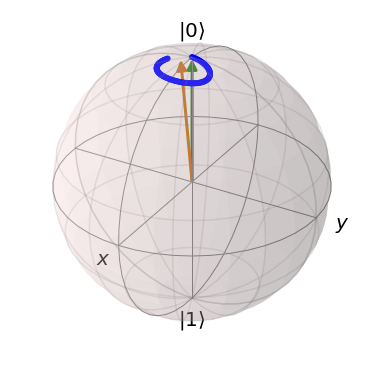

In [283]:
b = Bloch()

b.add_points(me_result.expect)

b.add_states(psi0)
b.add_states(U * psi0)
b.render()

# Process tomography

## Ideal gate

In [284]:
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]]
op_label = [["i", "x", "y", "z"]]

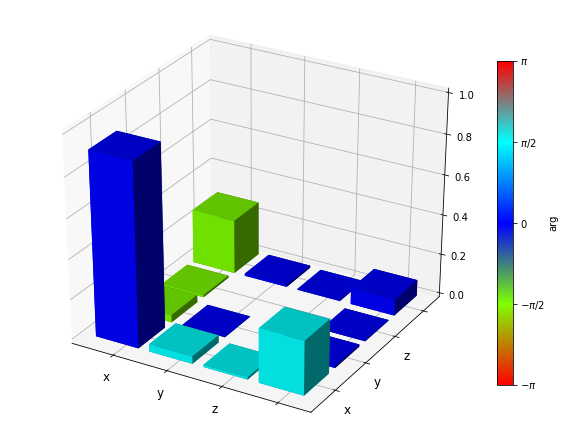

In [285]:
fig = plt.figure(figsize=(8,6))

U_ideal = spre(U) * spost(U.dag())

chi = qpt(U_ideal, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## Gate calculated using GRAPE

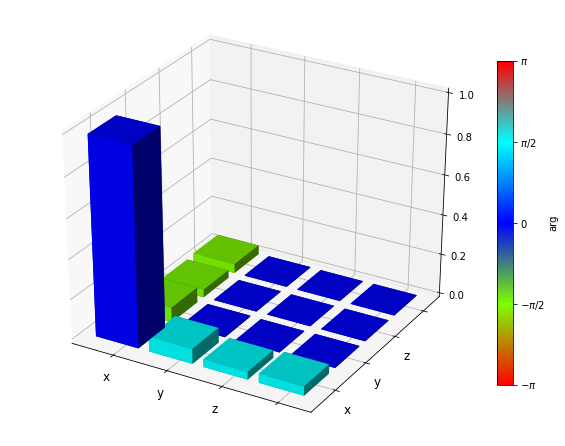

In [286]:
fig = plt.figure(figsize=(8,6))

U_ideal = spre(result.U_f) * spost(result.U_f.dag())

chi = qpt(U_ideal, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## Versions

In [287]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.5.1
Numpy,1.18.5
SciPy,1.4.1
matplotlib,3.2.2
Cython,0.29.20
Number of CPUs,4
BLAS Info,Generic
IPython,7.15.0
Python,"3.8.3 | packaged by conda-forge | (default, Jun 1 2020, 17:21:09) [Clang 9.0.1 ]"
OS,posix [darwin]
